In [1786]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import yfinance as yf

In [1787]:
# Parameters
test_size = 0.2

tickers_to_use = ['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N']
# tickers_to_use = ['AAPL.O']
n_tickers = len(tickers_to_use)

use_returns = False
discretize_returns = False
discretize_rsi = False
use_log_returns = False
use_past_positions = False
scaler = MinMaxScaler()
classification = False
num_classes = 2
single_model_for_all_tickers = False
margin_within = 0.007

window_length = 5
learning_rate = 0.00001
num_epochs = 100
batch_size = 32
dropout = 0.1
early_stopping_patience = 50

In [1788]:
raw = pd.read_csv('tr_eikon_eod_data.csv', index_col = 0, parse_dates = True)
data = pd.DataFrame(raw[tickers_to_use].dropna())
data

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N
Date,,,,,
2010-01-04,30.572827,30.950,20.88,133.90,173.08
2010-01-05,30.625684,30.960,20.87,134.69,176.14
2010-01-06,30.138541,30.770,20.80,132.25,174.26
2010-01-07,30.082827,30.452,20.60,130.00,177.67
2010-01-08,30.282827,30.660,20.83,133.52,174.31
...,...,...,...,...,...
2018-06-25,182.170000,98.390,50.71,1663.15,221.54
2018-06-26,184.430000,99.080,49.67,1691.09,221.58
2018-06-27,184.160000,97.540,48.76,1660.51,220.18


In [1789]:
data.corr()

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N
AAPL.O,1.000000,0.924437,0.920085,0.888065,0.766361
MSFT.O,0.924437,1.000000,0.950978,0.976018,0.839008
INTC.O,0.920085,0.950978,1.000000,0.909608,0.762886
AMZN.O,0.888065,0.976018,0.909608,1.000000,0.783544
GS.N,0.766361,0.839008,0.762886,0.783544,1.000000


In [1807]:
# Standard deviation of the data
print("Standard deviation of the tickers:")
print(data.std())

Standard deviation of the tickers:
AAPL.O     40.551559
MSFT.O     19.527712
INTC.O      8.172160
AMZN.O    372.307818
GS.N       42.483935
dtype: float64


In [1806]:
# Print the standard deviation of the prices in train and test sets
test_size = 0.2
print(data[:int(len(data) * (1 - test_size))].std())
# Print the standard deviation of the prices in test set
print(data[int(len(data) * (1 - test_size)):].std())

AAPL.O     28.130857
MSFT.O     10.143635
INTC.O      5.268343
AMZN.O    175.758492
GS.N       28.997224
dtype: float64
AAPL.O     22.727231
MSFT.O     12.969566
INTC.O      6.935527
AMZN.O    290.692329
GS.N       18.793846
dtype: float64


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

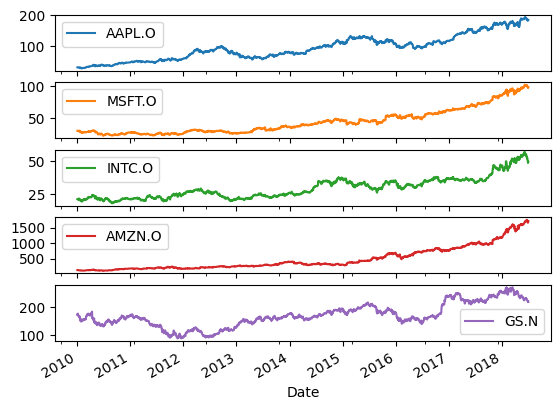

In [1790]:
data.plot(subplots = True)

In [1791]:
# Only for AAPL
# # Get first date point
# start_date = data.index.min()
# # Get last date point
# end_date = data.index.max() + pd.Timedelta(days = 1)
# # Get stock data
# stock_data = yf.download('AAPL', start = start_date, end = end_date)

In [1792]:
# # Join data and stock_data on date
# data = data.join(stock_data)
# data.drop('Adj Close', axis = 1, inplace = True)
# data.drop('Close', axis = 1, inplace = True)

In [1793]:
# # Add moving average of previous 40 business days and previous 150 business days as features
# for col in data.columns:
#     sma_short = data[col].shift(1).rolling(window = 40).mean()
#     sma_long = data[col].shift(1).rolling(window = 150).mean()
#     data[col + '_sma'] = np.where(sma_short > sma_long, 1, -1) # Another approach is to have both sma_short and sma_long as features

In [1794]:
# Add RSI as a feature
# def rsi(series, period):
#     delta = series.diff()
#     gain = (delta.where(delta > 0, 0)).rolling(window = period).mean()
#     loss = (-delta.where(delta < 0, 0)).rolling(window = period).mean()
#     rs = gain / loss
#     return 100 - (100 / (1 + rs))
# for col in data[tickers_to_use]:
#     data[col + '_RSI'] = rsi(data[col], 14)

In [1795]:
def calculate_rsi(data, window=10):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_ema(data, window=12):
    return data.ewm(span=window, adjust=False).mean()

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = calculate_ema(data, short_window)
    long_ema = calculate_ema(data, long_window)
    macd_line = short_ema - long_ema
    signal_line = calculate_ema(macd_line, signal_window)
    histogram = macd_line - signal_line
    return macd_line, signal_line, histogram

In [1796]:
def rsi_trading_strategy(rsi_data, low=30, high=70):
    buy_signal = (rsi_data.shift(1) < low) & (rsi_data > low)
    sell_signal = (rsi_data.shift(1) > high) & (rsi_data < high)
    return buy_signal.astype(int) - sell_signal.astype(int)

def macd_trading_strategy(macd_line, signal_line):
    buy_signal = macd_line.shift(1) < signal_line.shift(1)
    sell_signal = macd_line.shift(1) > signal_line.shift(1)
    return buy_signal.astype(int) - sell_signal.astype(int)

In [1797]:
data.dropna(inplace = True)

In [1798]:
data

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N
Date,,,,,
2010-01-04,30.572827,30.950,20.88,133.90,173.08
2010-01-05,30.625684,30.960,20.87,134.69,176.14
2010-01-06,30.138541,30.770,20.80,132.25,174.26
2010-01-07,30.082827,30.452,20.60,130.00,177.67
2010-01-08,30.282827,30.660,20.83,133.52,174.31
...,...,...,...,...,...
2018-06-25,182.170000,98.390,50.71,1663.15,221.54
2018-06-26,184.430000,99.080,49.67,1691.09,221.58
2018-06-27,184.160000,97.540,48.76,1660.51,220.18


In [1799]:
def prepare_data(data, features, target_feature_indices, rsi_index = None):
    ticker_data = data[features].values

    if use_returns:
        returns = ticker_data[1:, target_feature_indices] / ticker_data[:-1, target_feature_indices] - 1
        remaining_features = np.delete(ticker_data, target_feature_indices, axis = 1)[1:, :]
        features = np.column_stack((returns, remaining_features))
    elif use_log_returns:
        returns = np.log(ticker_data[1:, target_feature_indices] / ticker_data[:-1, target_feature_indices])
        remaining_features = np.delete(ticker_data, target_feature_indices, axis = 1)[1:, :]
        features = np.column_stack((returns, remaining_features))

    if (use_returns or use_log_returns) and discretize_returns:
        bins = defaultdict(list)
        for i in range(len(target_feature_indices)):
            bins[i] = [np.mean(returns[:, i]) - 2 * np.std(returns[:, i]), np.mean(returns[:, i]) - np.std(returns[:, i]), np.mean(returns[:, i]), np.mean(returns[:, i]) + np.std(returns[:, i]), np.mean(returns[:, i]) + 2 * np.std(returns[:, i])]
        for i in range(len(returns)):
            for j in range(len(target_feature_indices)):
                features[i, j] = np.digitize(returns[i, j], bins[j])
    elif use_past_positions:
        features = np.zeros((len(ticker_data) - 1, len(ticker)))
        for i in range(1, len(ticker_data)):
            for j in range(len(target_feature_indices)):
                features[i - 1, j] = np.where(ticker_data[i, j] > ticker_data[i - 1, j], 1, 0)
        remaining_features = np.delete(ticker_data, target_feature_indices, axis = 1)[1:, :]
        features = np.column_stack((features, remaining_features))
    else:
        features = ticker_data

    if rsi_index is not None and discretize_rsi:
        # discretize features[rsi_index]
        bins = [0, 30, 70, 100]
        features[:, rsi_index] = np.digitize(features[:, rsi_index], bins)
    
    features_scaled = features
    if scaler:
        features_scaled = scaler.fit_transform(features)

    X, Y = [], []
    for i in range(len(features_scaled) - window_length):
        X.append(features_scaled[i:i + window_length])
        if classification:
            if use_returns or use_log_returns:
                Y.append(np.where(returns[i + window_length, target_feature_indices] > 0, 1, 0))
            elif use_past_positions:
                Y.append(features[i + window_length, target_feature_indices])
            else:
                Y.append(np.where(ticker_data[i + window_length, target_feature_indices] > ticker_data[i + window_length - 1, target_feature_indices], 1, 0))
        else:
            if use_returns or use_log_returns:
                Y.append(returns[i + window_length, target_feature_indices])
            else:
                Y.append(features_scaled[i + window_length, target_feature_indices])
    return np.array(X), np.array(Y)

In [1800]:
def build_model(input_shape):
    input_layer = Input(shape = input_shape)
    shared_lstm = LSTM(100, activation = 'relu', return_sequences = True)(input_layer)
    shared_lstm = Dropout(dropout)(shared_lstm)
    shared_lstm = LSTM(100, activation = 'relu', return_sequences = True)(shared_lstm)
    shared_lstm = Dropout(dropout)(shared_lstm)
    # shared_lstm = LSTM(200, activation = 'relu', return_sequences = True)(shared_lstm)
    # shared_lstm = Dropout(dropout)(shared_lstm)
    shared_lstm = LSTM(50, activation = 'relu', return_sequences = False)(shared_lstm)
    # shared_lstm = Dropout(dropout)(shared_lstm)
    if single_model_for_all_tickers:
        n_features_to_predict = len(tickers_to_use)
    else:
        n_features_to_predict = 1
    if classification:
        outputs = []
        for i in range(n_features_to_predict):
            output = Dense(num_classes, activation = 'softmax', name = 'output_' + str(i + 1))(shared_lstm)
            outputs.append(output)
        model = Model(inputs = input_layer, outputs = outputs)
        model.compile(optimizer = Adam(learning_rate = learning_rate), loss = 'categorical_crossentropy', metrics = ['accuracy'] * n_features_to_predict)
    else:
        output = Dense(n_features_to_predict, activation = 'linear')(shared_lstm)
        model = Model(inputs = input_layer, outputs = output)
        model.compile(optimizer = Adam(learning_rate = learning_rate), loss = 'mean_squared_error')
    return model

In [1801]:
if single_model_for_all_tickers:
    X, Y = prepare_data(data, data.columns, list(range(n_tickers)))
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, shuffle = False)
    model = build_model((window_length, n_tickers))
    if classification:
        Y_train = to_categorical(Y_train)
        Y_test = to_categorical(Y_test)
        Y_train_dict = {}
        Y_test_dict = {}
        for i in range(n_tickers):
            Y_train_dict['output_' + str(i + 1)] = Y_train[:,i,:]
            Y_test_dict['output_' + str(i + 1)] = Y_test[:,i,:]
        model.fit(X_train, Y_train_dict, epochs = num_epochs, batch_size = batch_size, validation_data = (X_test, Y_test_dict))
    else:
        model.fit(X_train, Y_train, epochs = num_epochs, batch_size = batch_size, validation_data = (X_test, Y_test))
else:
    models = {}
    test_data = {}
    for ticker in tickers_to_use:
        features_used = [ticker]
        X, Y = prepare_data(data, features_used, [0])
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size, shuffle = False)
        # Choose first column of Y as target
        if Y_train.ndim == 2:
            Y_train = Y_train[:,0].reshape(-1, 1)
            Y_test = Y_test[:,0].reshape(-1, 1)
        else:
            Y_train = Y_train.reshape(-1, 1)
            Y_test = Y_test.reshape(-1, 1)
        print(Y_train[:10])
        test_data[ticker] = (X_test, Y_test)
        model = build_model((window_length, len(features_used)))
        if classification:
            Y_train = to_categorical(Y_train)
            Y_test = to_categorical(Y_test)
            Y_train_dict = {'output_1': Y_train}
            Y_test_dict = {'output_1': Y_test}
            print(Y_train.shape, X_train.shape, Y_test.shape, X_test.shape)
            model.fit(X_train, Y_train_dict, epochs = num_epochs, batch_size = batch_size, validation_data = (X_test, Y_test_dict))
        else:
            early_stopping = EarlyStopping(monitor = 'val_loss', patience = early_stopping_patience, restore_best_weights = True)
            model.fit(X_train, Y_train, epochs = num_epochs, batch_size = batch_size, validation_data = (X_test, Y_test))
        models[ticker] = model

[[0.01549136]
 [0.01344128]
 [0.01595455]
 [0.01490807]
 [0.01190587]
 [0.01972017]
 [0.01687666]
 [0.01374322]
 [0.0048893 ]
 [0.00945693]]
Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.1189 - val_loss: 0.5975
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1187 - val_loss: 0.5873
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1151 - val_loss: 0.5762
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1118 - val_loss: 0.5636
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1100 - val_loss: 0.5487
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.1055 - val_loss: 0.5329
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0972 - val_loss: 0.5157
Epoch 8/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0957 - val_loss: 0.4970
Epoch 9/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0853 - val_loss: 0.4762
Epoch 10/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0796 - val_loss: 0.453

In [1802]:
def generate_signals(prices, true_price, pct_within=0.05):
    signals = np.zeros(len(prices))
    for i in range(1, len(prices)):
        prev_price = true_price[i - 1]
        current_price = prices[i]
        upper_bound = prev_price * (1 + pct_within)
        lower_bound = prev_price * (1 - pct_within)
        
        if current_price >= lower_bound and current_price <= upper_bound:
            if signals[i - 1] == 0:
                signals[i] = 1 if current_price > prev_price else -1
            else:
                signals[i] = signals[i - 1]
        elif current_price > upper_bound:
            signals[i] = 1  # Buy signal
        elif current_price < lower_bound:
            signals[i] = -1  # Sell signal
    
    return signals

## Returns without tweaking the parameters

In [ ]:
for stock in tickers_to_use:
    stock_predictions = y_pred[:,tickers_to_use.index(stock)]
    stock_predictions = pd.Series(stock_predictions)
    stock_values = testing_data[stock][stock]

    other_signals_1 = generate_signals(stock_predictions.values, stock_predictions.values, pct_within)
    other_signals_2 = generate_signals(stock_predictions.values, stock_values.values, pct_within)
    returns = other_signals_1 * testing_data[stock]['Returns']
    print(stock, np.exp(returns.sum()))
    returns = other_signals_2 * testing_data[stock]['Returns']
    print(stock, np.exp(returns.sum()))
    print(stock, np.exp(testing_data[stock]['Returns'].sum()))


AAPL.O 1.2116568745809286
AAPL.O 0.5180332588638599
AAPL.O 1.580515710382514
MSFT.O 1.067668451980722
MSFT.O 0.9219891431548601
MSFT.O 1.7140622284025726
INTC.O 1.8223659503291019
INTC.O 0.6787224405057993
INTC.O 1.3998873556744589
AMZN.O 1.0612666484890965
AMZN.O 0.6280228806160426
AMZN.O 2.078782912839833
GS.N 0.8378191684226795
GS.N 0.9407119317626614
GS.N 1.2639390292819888


## Returns after tweaking the parameters

In [1803]:
from collections import defaultdict
    
if single_model_for_all_tickers:
    y_pred = model.predict(X_test)
else:
    y_pred = np.zeros((len(X_test), n_tickers))
    i = 0
    for ticker in tickers_to_use:
        X_test, Y_test = test_data[ticker]
        y_pred_temp = models[ticker].predict(X_test)
        print(y_pred_temp[:10])
        if classification:
            if y_pred_temp.ndim == 3:
                y_pred_temp = np.argmax(y_pred_temp, axis = 2)
            elif y_pred_temp.ndim == 2:
                y_pred_temp = np.argmax(y_pred_temp, axis = 1)
            y_pred_temp = np.where(y_pred_temp == 0, -1, y_pred_temp)
        if y_pred_temp.ndim == 2:
            y_pred_temp = y_pred_temp.flatten()
        y_pred[:,i] = y_pred_temp
        i += 1
testing_data = {}
entire_data = {}
training_data = {}
for stock in tickers_to_use:
    entire_data[stock] = data[stock]
    testing_data[stock] = pd.DataFrame(test_data[stock][1].flatten(), columns = [stock])
    testing_data[stock]['unscaled'] = pd.DataFrame(data[stock].iloc[-len(y_pred):]).values
    testing_data[stock]['Returns'] = np.log(testing_data[stock]['unscaled'] / testing_data[stock]['unscaled'].shift(1))

for stock in tickers_to_use:
    stock_predictions = y_pred[:,tickers_to_use.index(stock)]
    stock_predictions = pd.Series(stock_predictions)
    stock_values = testing_data[stock][stock]
    max_return = -np.inf
    best_low = None
    best_high = None
    best_window = None
    best_pct_within = None
    for window in range(5, 30, 2):
        stock_rsi = calculate_rsi(stock_predictions, window)
        macd_line, signal_line, histogram = calculate_macd(stock_predictions)
        stock_macd = macd_line - signal_line
        for low in range(25, 40, 2):
            for high in range(60, 65, 1):
                for pct_within in np.linspace(0.0, 0.01, 100):
                    rsi_signals = rsi_trading_strategy(stock_rsi, low, high)
                    rsi_signals = np.where(rsi_signals > 0, 1, -1)
                    macd_signals = macd_trading_strategy(macd_line, signal_line)
                    macd_signals = np.where(macd_signals > 0, 1, -1)
                    other_signals_1 = generate_signals(stock_predictions.values, stock_predictions.values, pct_within)
                    other_signals_2 = generate_signals(stock_predictions.values, stock_values.values, pct_within)

                    # Use the majority vote to determine the final signal
                    signals = rsi_signals + macd_signals + other_signals_1
                    signals = np.where(signals > 0, 1, -1)
                    returns = signals * testing_data[stock]['Returns']
                    if np.exp(returns.sum()) > max_return:
                        max_return = np.exp(returns.sum())
                        best_low = low
                        best_high = high
                        best_window = window
                        best_pct_within = pct_within
                    
                    # Use the majority vote to determine the final signal
                    signals = rsi_signals + macd_signals + other_signals_2
                    signals = np.where(signals > 0, 1, -1)
                    returns = signals * testing_data[stock]['Returns']
                    if np.exp(returns.sum()) > max_return:
                        max_return = np.exp(returns.sum())
                        best_low = low
                        best_high = high
                        best_window = window
                        best_pct_within = pct_within
                    
                    signals = np.where((stock_rsi < low) & (stock_macd > 0), 1,
                                np.where((stock_rsi > high) & (stock_macd < 0), -1, 0))
                    for i in range(1, len(testing_data)):
                        if signals[i] == 0:
                            signals[i] = signals[i - 1]
                    returns = signals * testing_data[stock]['Returns']
                    if np.exp(returns.sum()) > max_return:
                        max_return = np.exp(returns.sum())
                        best_low = low
                        best_high = high
                        best_window = window
                        best_pct_within = pct_within

                    signals = np.where((stock_rsi < low) & (stock_macd > 0), 1,
                                np.where((stock_rsi > high) & (stock_macd < 0), -1, 0))
                    returns = signals * testing_data[stock]['Returns']
                    if np.exp(returns.sum()) > max_return:
                        max_return = np.exp(returns.sum())
                        best_low = low
                        best_high = high
                        best_window = window
                        best_pct_within = pct_within
                    
                    # Only other_signals_1
                    signals = other_signals_1
                    signals = np.where(signals > 0, 1, -1)
                    returns = signals * testing_data[stock]['Returns']
                    if np.exp(returns.sum()) > max_return:
                        max_return = np.exp(returns.sum())
                        best_low = low
                        best_high = high
                        best_window = window
                        best_pct_within = pct_within
                    # Only rsi_signals
                    signals = rsi_signals
                    signals = np.where(signals > 0, 1, -1)
                    returns = signals * testing_data[stock]['Returns']
                    if np.exp(returns.sum()) > max_return:
                        max_return = np.exp(returns.sum())
                        best_low = low
                        best_high = high
                    # Only macd_signals
                    signals = macd_signals
                    signals = np.where(signals > 0, 1, -1)
                    returns = signals * testing_data[stock]['Returns']
                    if np.exp(returns.sum()) > max_return:
                        max_return = np.exp(returns.sum())
                        best_low = low
                        best_high = high
                    # Only other_signals_2
                    signals = other_signals_2
                    signals = np.where(signals > 0, 1, -1)
                    returns = signals * testing_data[stock]['Returns']
                    if np.exp(returns.sum()) > max_return:
                        max_return = np.exp(returns.sum())
                        best_low = low
                        best_high = high
    print(stock, best_low, best_high, best_window, best_pct_within, max_return, np.exp(testing_data[stock]['Returns'].sum()))

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step 
[[0.5384269 ]
 [0.538408  ]
 [0.53938955]
 [0.53859395]
 [0.53777885]
 [0.5372849 ]
 [0.537275  ]
 [0.53642476]
 [0.5360746 ]
 [0.53168404]]
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
[[0.4253182 ]
 [0.42593852]
 [0.42814544]
 [0.4289689 ]
 [0.43288654]
 [0.43713403]
 [0.44528708]
 [0.4596296 ]
 [0.464339  ]
 [0.4620208 ]]
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
[[0.49002996]
 [0.4897161 ]
 [0.4894244 ]
 [0.48188424]
 [0.47182366]
 [0.45035017]
 [0.4476017 ]
 [0.44435114]
 [0.44333696]
 [0.44008464]]
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
[[0.42886913]
 [0.42654267]
 [0.42421773]
 [0.422743  ]
 [0.42392358]
 [0.42451742]
 [0.425376  ]
 [0.428599  ]
 [0.4296613 ]
 [0.42515194]]
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
[[0.43925112]
 [0.44066843]
 [0.44974995]
 [0.4539132 ]
 [0.464751  ]
 [0.46920094]
 [0.47042862]
 [0.47284803]
 [0.4761449 ]
 [0.4798452 ]]
AAPL.O 25 60 5 0.000505050505050505 1.5681761353413428 1.580515710382514
MSFT.O 25 60 5 0.0 1.